In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

#Now everyone can replicate or results.
np.random.seed(200419)

tweetsok= pd.read_csv("full_neuron_testing.csv")
tweetsok.head()

,User,Text,Date,Favorites,Retweets,Mentions,Hashtags,Geolocation,Prediction
0,actualidadpanam,Vacuna rusa será vendida en sanandresitos. Ven...,2020-08-11 23:57:51+00:00,990,5057,NaN,NaN,NaN,1
1,actualidadpanam,Le ponen comparendo porque su permiso de movil...,2020-08-11 23:41:26+00:00,151,696,NaN,NaN,NaN,1
2,actualidadpanam,Película '¿Y dónde está el piloto?' predijo la...,2020-08-11 19:43:44+00:00,25,176,NaN,NaN,NaN,1
3,actualidadpanam,"Para marzo de 2021, primer piloto de felicidad.",2020-08-11 17:50:43+00:00,63,348,NaN,NaN,NaN,1
4,actualidadpanam,Con vuelos Engativá-Suba y Fontibón-Usaquén co...,2020-08-11 17:40:35+00:00,381,2180,NaN,NaN,NaN,1


In [2]:
def standarize_column_name(col):
    return col.lower().replace(' ','_').replace('/','_')

In [3]:
#Cleaning database
tweetsok.rename(columns={element: standarize_column_name(element) for element in
                         tweetsok.columns.values}, inplace=True)

tweetsok = tweetsok.replace(np.nan, '', regex=True)
tweetsok.head()

,user,text,date,favorites,retweets,mentions,hashtags,geolocation,prediction
0,actualidadpanam,Vacuna rusa será vendida en sanandresitos. Ven...,2020-08-11 23:57:51+00:00,990,5057,,,,1
1,actualidadpanam,Le ponen comparendo porque su permiso de movil...,2020-08-11 23:41:26+00:00,151,696,,,,1
2,actualidadpanam,Película '¿Y dónde está el piloto?' predijo la...,2020-08-11 19:43:44+00:00,25,176,,,,1
3,actualidadpanam,"Para marzo de 2021, primer piloto de felicidad.",2020-08-11 17:50:43+00:00,63,348,,,,1
4,actualidadpanam,Con vuelos Engativá-Suba y Fontibón-Usaquén co...,2020-08-11 17:40:35+00:00,381,2180,,,,1


In [4]:
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('wordnet')

import string


# List of spanish words
stop_words= get_stop_words('spanish')

from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()  

words_in_t = [] #all tokens in true articles
words_in_f = [] #all tokens in fake articles
words_in_each_article_t = [] #list of true articles, each in tokenized form
words_in_each_article_f = [] #list of fake articles, each in tokenized form

def process(df, word_list, by_article_list):
  for article in (df["text"]):
    words = word_tokenize(article)
    words = [word.lower() for word in words if word.isalpha()] #lowercase
    words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
    words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form

    by_article_list.append(words)
    for w in words:
      word_list.append(w)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oselm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
fakes=tweetsok[tweetsok['prediction']==1]['text'].reset_index()

trues=tweetsok[tweetsok['prediction']==0]['text'].reset_index()

#Create column with labels
fakes['label'] = 1
trues['label'] = 0

fakes["date"] = tweetsok["date"]
trues['date'] = tweetsok["date"]

#Convert dates to right format
trues["date"] = trues["date"].apply(pd.to_datetime)
fakes["date"] = fakes["date"].apply(pd.to_datetime)

print(fakes.shape)
print(trues.shape)

(5829, 4)
(10000, 4)


In [6]:
process(fakes, words_in_f, words_in_each_article_f)
process(trues, words_in_t, words_in_each_article_t)

In [7]:
#Get tokenized forms of all in one dataframe
X = []
for a in words_in_each_article_t:
  X.append(a)
for b in words_in_each_article_f:
  X.append(b)

y = pd.concat([trues["label"], fakes["label"]])


#Free some space
del tweetsok

##Separate training and test.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test =train_test_split(X,y,test_size=0.3, random_state=200419)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Keep words that appear in greater than 3% of documents.
#Implement on list of words in each article in order to keep the words we have cleaned for earlier
tfidf = TfidfVectorizer(min_df = 0.03, preprocessor = ' '.join)

#Implement on train dataset
response_train = tfidf.fit_transform(x_train) #This is the Sparse Document-Term Matrix
feature_names_train = tfidf.get_feature_names()
dense_train = response_train.todense() #This is the Dense Document-Term Matrix
denselist_train = dense_train.tolist()

In [9]:
df_train = pd.DataFrame(denselist_train, columns=feature_names_train)
df_train

,amp,aquí,así,años,bogotá,colombia,contamos,coronavirus,cuarentena,detalles,historia,http,pandemia,país,persona,vía
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0
1,0.000000,0.669413,0.0,0.0,0.0,0.0,0.742890,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11075,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
11076,0.865842,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.500317,0.000000,0.0,0.0,0.0
11077,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
11078,0.000000,0.000000,0.0,0.0,0.0,0.0,0.632719,0.0,0.0,0.0,0.0,0.269371,0.726021,0.0,0.0,0.0


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor = ' '.join, vocabulary = feature_names_train)

#Implement on test dataset
response_test = tfidf.fit_transform(x_test) #This is the Sparse Document-Term Matrix
feature_names_test = tfidf.get_feature_names()
dense_test = response_test.todense() #This is the Dense Document-Term Matrix
denselist_test = dense_test.tolist()

In [11]:
df_test = pd.DataFrame(denselist_test, columns=feature_names_test)
df_test

,amp,aquí,así,años,bogotá,colombia,contamos,coronavirus,cuarentena,detalles,historia,http,pandemia,país,persona,vía
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000
3,0.423541,0.528087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.694561,0.243560,0.0,0.0,0.0,0.000000
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
4745,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000
4746,0.866885,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.498508,0.0,0.0,0.0,0.000000
4747,0.535886,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.308165,0.0,0.0,0.0,0.786041


In [12]:
## Configuración del RF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

# n_estimators are the number of trees to create
grid = {'n_estimators': [300,500], 'min_samples_leaf': [2,3], 
       'criterion':['gini','entropy']}

rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
gs_rf = GridSearchCV(rf, grid, cv=3, scoring='f1', return_train_score=True, n_jobs=-1)

start = time.time()

# Training Random Forest
gs_rf.fit(df_train, y_train)
print("tiempo de ejecución en segundos: {}".format(time.time() - start))

tiempo de ejecución en segundos: 30.342443704605103


In [13]:
# Best estimator
gs_rf.best_estimator_


RandomForestClassifier(criterion='entropy', min_samples_leaf=3,
                       n_estimators=300, n_jobs=-1, oob_score=True)

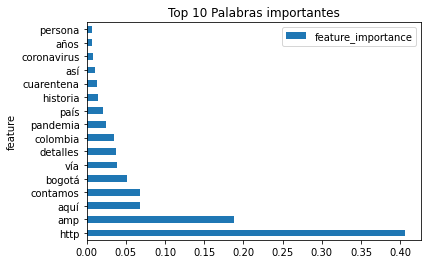

In [14]:
import matplotlib.pyplot as plt

rfi = pd.Series(gs_rf.best_estimator_.feature_importances_).sort_values(ascending=False)

names = pd.Series(df_train.columns.values)

rf_1 = pd.DataFrame({'feature_importance': rfi, 'column': rfi.index})
#rf_1

rf_2 = pd.DataFrame({'feature': names, 'column': names.index})
#rf_2

feature_importances_df = rf_2.merge(rf_1)
importance= feature_importances_df.sort_values(by='feature_importance', ascending=False)

importance.plot(kind='barh', x='feature', y='feature_importance')
plt.title("Top 10 Palabras importantes")
plt.show()

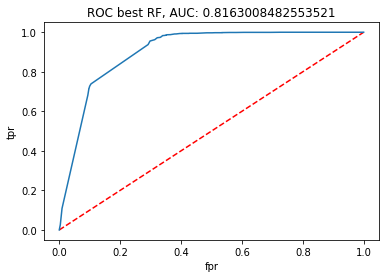

In [15]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predictions best estimator
predicted_labels = gs_rf.predict(df_test)

# Prediction scores best estimator
predicted_scores = gs_rf.predict_proba(df_test)

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

thresholds_2 = np.append(thresholds_2, 1)

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix

rf_cm= confusion_matrix(y_test, predicted_labels)
rf_cm


array([[2705,  311],
       [ 458, 1275]], dtype=int64)

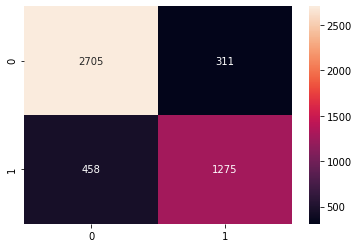

In [17]:
import seaborn as sns

labels = np.array([['2705','311'],['458','1275']])
sns.heatmap(rf_cm, annot=labels, fmt = '')
plt.show()